# Model

## Import Section

In [1]:
import numpy as np
import pandas as pd

import pickle

from matplotlib import pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import KFold

from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
# import lightgbm as lgbm
# import catboost as catb

# from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

## Path Section

In [2]:
PATH_DATA_TRAIN = 'data/course_project_train.csv'
PATH_DATA_TEST = 'data/course_project_test.csv'

PATH_DATA_TRAIN_PREPROCESSED = 'data/train_preprocessed.pkl'
PATH_DATA_TEST_PREPROCESSED = 'data/test_preprocessed.pkl'

# PATH_VALUE_ANNUAL_INCOME_MEDIAN = 'data/annual_income_median.pkl'
# PATH_VALUE_CURRENT_LOAN_AMOUNT_QUANTILE = 'data/current_loan_amount_quantile.pkl'
# PATH_VALUE_CREDIT_SCORE_MEDIAN = 'data/credit_score_median.pkl'

PATH_MODEL_XGB = 'data/model_xgb.pkl'

PATH_DATA_RESULT = 'ZakharchenkoSV_predictions.csv'

### Function "Reduce Memory Usage"

In [3]:
def reduce_memory_usage(df):
    
    # СДЕЛАТЬ ПРОВЕРКУ type(df) == pd.DataFrame
    
    initial_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Initial memory usage of dataframe:\t{initial_memory_usage:.3} Mb')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            # Можно было бы сделать оптимизацию вплоть до типа "float16", однако данный тип данных,
            # как сообщается от сообщества аналитиков данных, плохо поддерживается некоторыми библиотеками
            
            if str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
        
        else:
            df[col] = df[col].astype('category')
    
    final_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Final memory usage of dataframe:\t{final_memory_usage:.3} Mb')
    
    comparison = np.round(100 * (initial_memory_usage - final_memory_usage) / initial_memory_usage, 3)
    print(f'Memory usage has been decreased by:\t{comparison} %')
    
    return df

### Function "Show Feature Importances"

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sn.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Function "Classification Report"

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## Exploratory Data Analysis

In [6]:
X_train = pd.read_csv(PATH_DATA_TRAIN)

#### Common information about df "X_train"

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [8]:
X_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [9]:
X_train.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

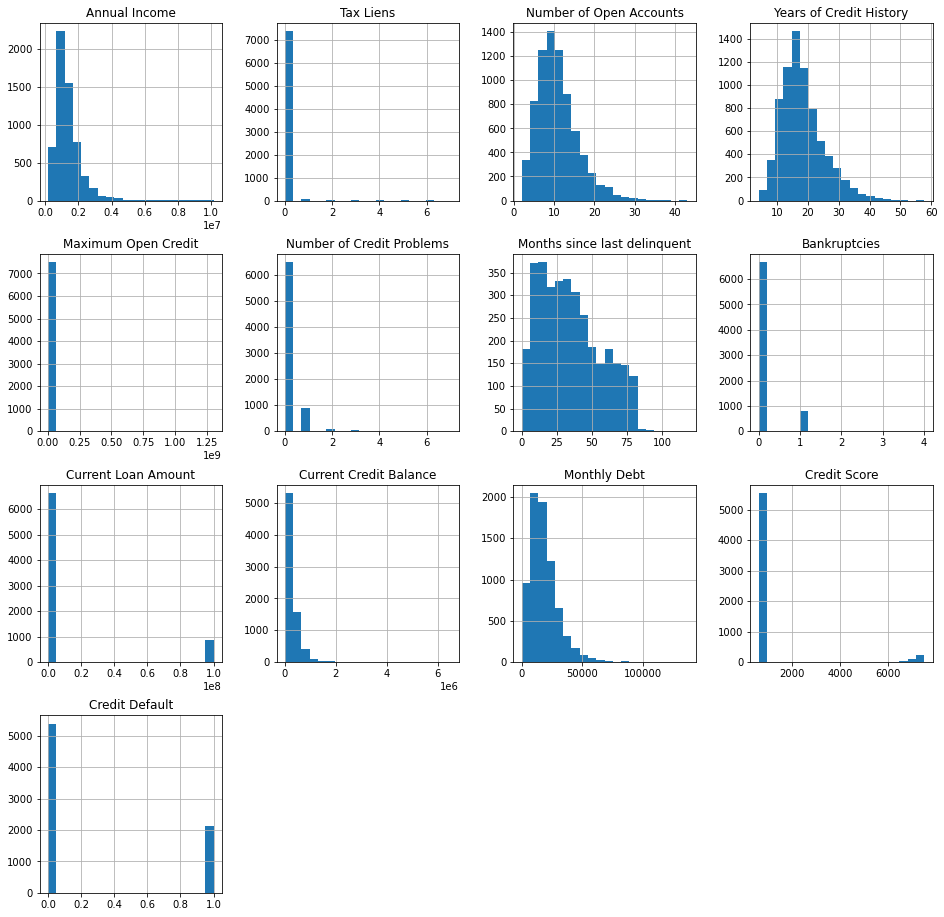

In [10]:
X_train.hist(figsize = (16, 16), bins = 20)

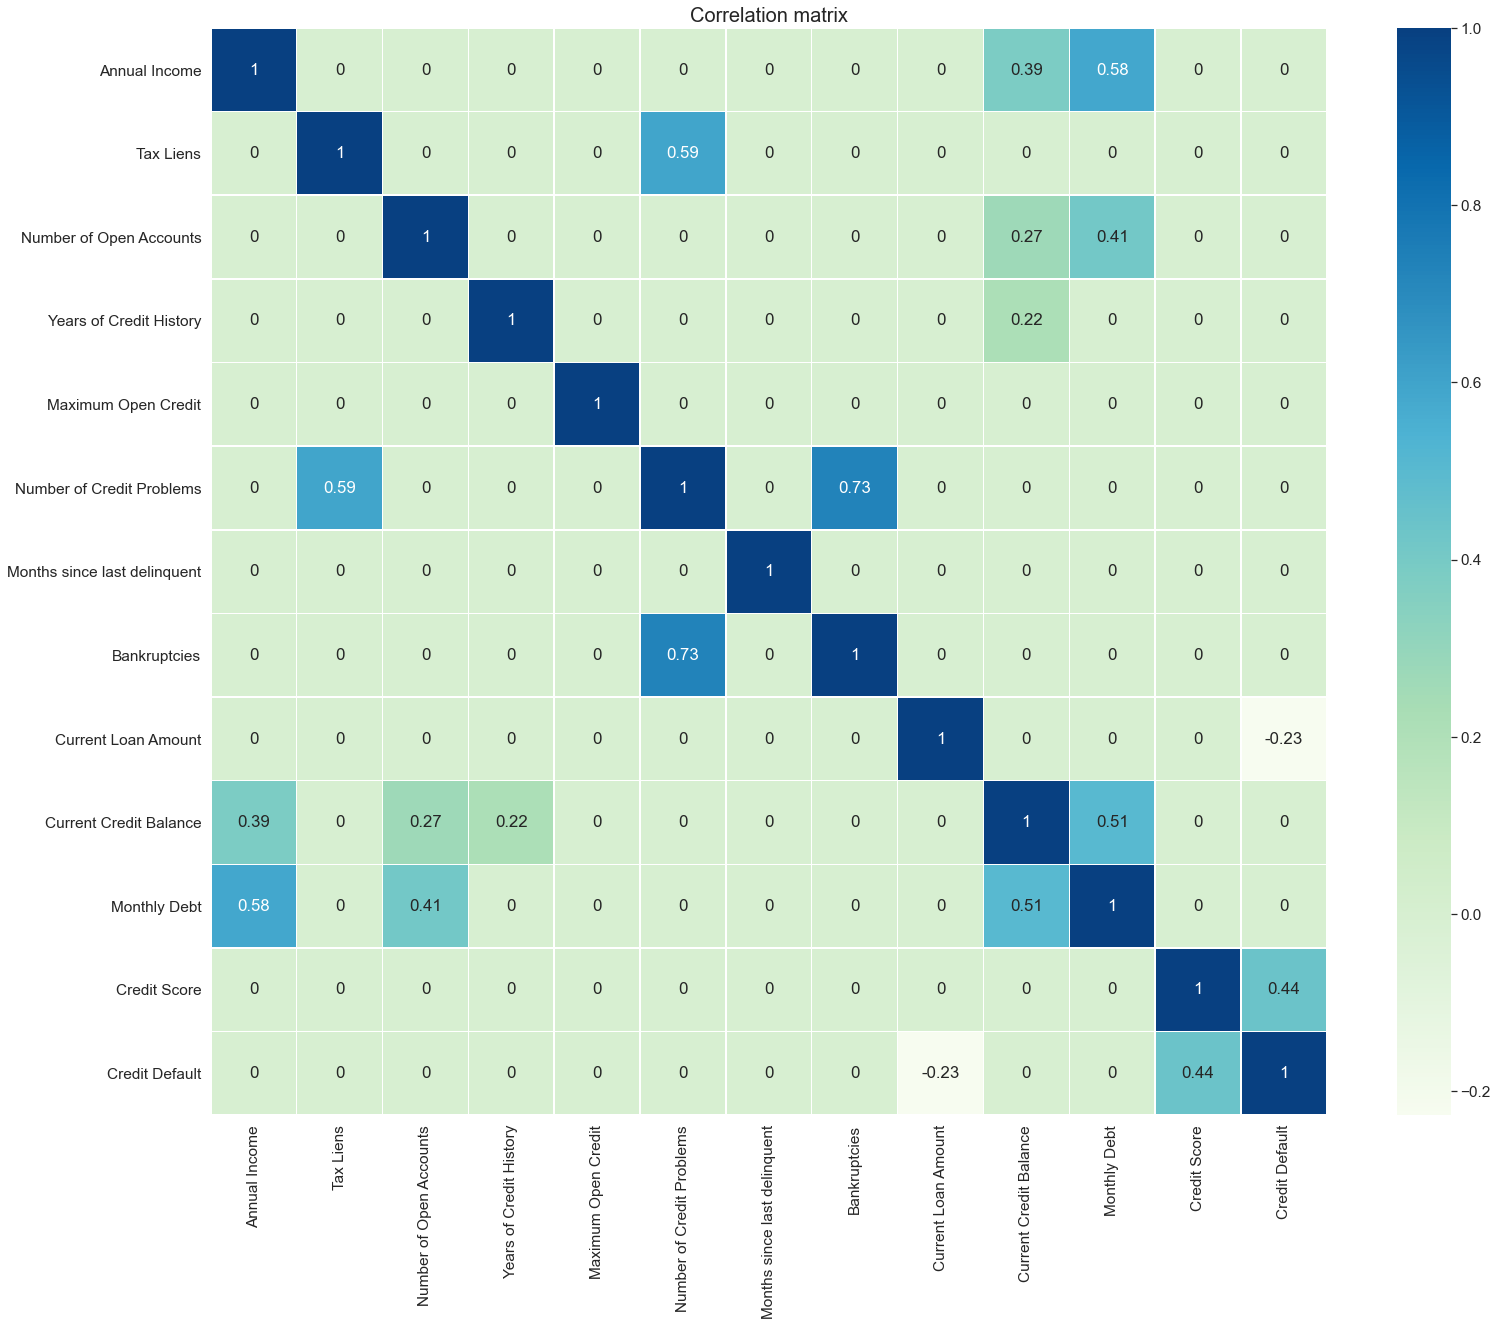

In [11]:
X_corr = X_train.corr()
X_corr = np.round(X_corr, 3)
X_corr[np.abs(X_corr) < 0.2] = 0

plt.figure(figsize = (25, 20))

sn.set(font_scale=1.4)
sn.heatmap(data = X_corr, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix', fontsize = 20)

plt.show()

Согласно матрице корреляций существенное влияние на целевую переменную оказывает признак "Credit Score". Также наблюдается зависимость от признака "Current Loan Amount".

Следовательно, упомянутые признаки наиболее важны для точного предсказания целевой переменной и должны быть подробно рассмотрены.

#### Data gaps

In [12]:
len(X_train) - X_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### Home Ownership - домовладение

In [13]:
X_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Данный признак можно конвертировать в dummies переменные.

Не содержит пропусков.

#### Annual Income - годовой доход

In [14]:
X_train['Annual Income'].value_counts().shape[0]

5478

<Figure size 1080x720 with 0 Axes>

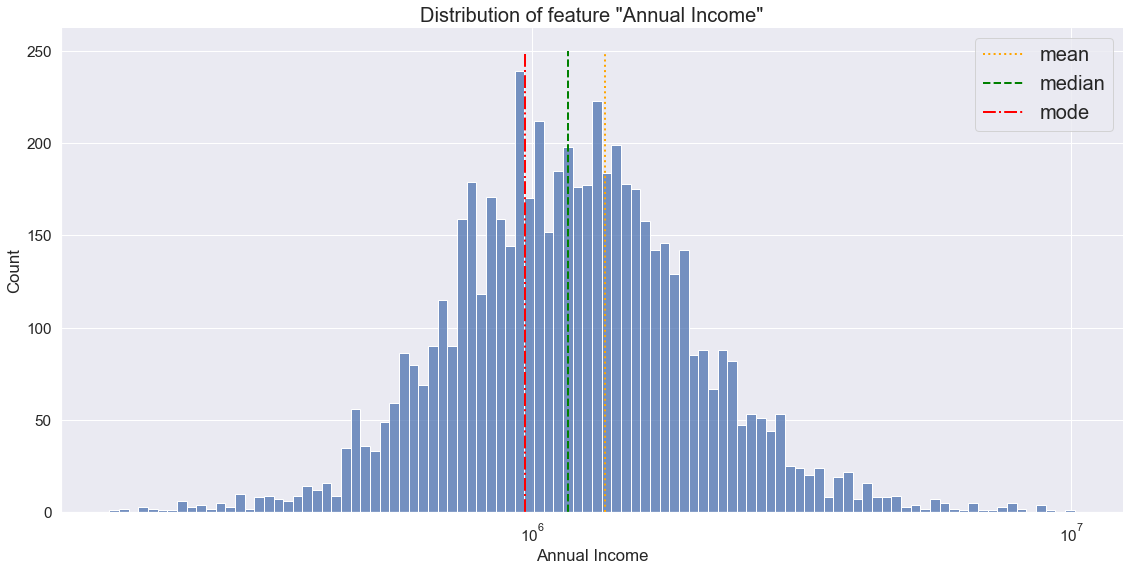

In [15]:
plt.figure(figsize = (15, 10))

sn.displot(X_train['Annual Income'], bins = 100, height = 8, aspect = 2, log_scale = True)

y = np.linspace(0, 250, 10)

plt.plot([np.round(X_train['Annual Income'].mean(), 2)] * 10, y, linewidth = 2, color = 'orange', linestyle = ':', label = 'mean')
plt.plot([np.round(X_train['Annual Income'].median(), 2)] * 10, y, linewidth = 2, color = 'green', linestyle = '--', label = 'median')
plt.plot([np.round(X_train['Annual Income'].mode()[0], 2)] * 10, y, linewidth = 2, color = 'red', linestyle = '-.', label = 'mode')

plt.legend(fontsize = 20)
plt.title('Distribution of feature "Annual Income"', fontsize = 20)

# plt.savefig('img/.png')

plt.show()

In [16]:
print(f"Mean:\t{np.round(X_train['Annual Income'].mean())}")
print(f"Median:\t{np.round(X_train['Annual Income'].median())}")
print(f"Mode:\t{np.round(X_train['Annual Income'].mode()[0])}")
print(f"Min:\t{np.round(X_train['Annual Income'].min())}")
print(f"Max:\t{np.round(X_train['Annual Income'].max())}")
print(f"Gaps:\t{X_train.shape[0] - X_train['Annual Income'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Annual Income'].count()) / X_train.shape[0]) * 100, 2)}")

Mean:	1366392.0
Median:	1168386.0
Mode:	969475.0
Min:	164597.0
Max:	10149344.0
Gaps:	1557
Gaps %:	20.76


Данный признак содержит значительное кол-во выбросов, более 20%, что не позволяет исключить записи с пропусками из массива данных.

Таким образом, пропущенные значения следует заполнить основными статистиками или сгенерировать.

#### Years in current job - количество лет на текущем месте работы

In [17]:
X_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [18]:
print(f"Gaps:\t{X_train.shape[0] - X_train['Years in current job'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Years in current job'].count()) / X_train.shape[0]) * 100, 2)}")

Gaps:	371
Gaps %:	4.95


Данный признак содежит незначительное кол-во выбросов, менее 5%, однако в целях сохрания массива данных потребуется заполнение.

Возможно, данный признак лучше использовать как категориальный.

#### Tax Liens - налоговые обременения

In [19]:
X_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [20]:
print(f"Moda %:\t{np.round((X_train['Tax Liens'].value_counts()[0] / X_train['Tax Liens'].count()) * 100, 2)}")

Moda %:	98.21


Мода данного признака занимает более 98% всей выборки, что делает остальные значения незначительными.

Возможно, значения, отличные от моды, следует объединить в отдельную категорию. Или же преобразовать признак в две dummies переменные.

Не содержит пропусков.

#### Number of Open Accounts - количество открытых счетов

<Figure size 1080x720 with 0 Axes>

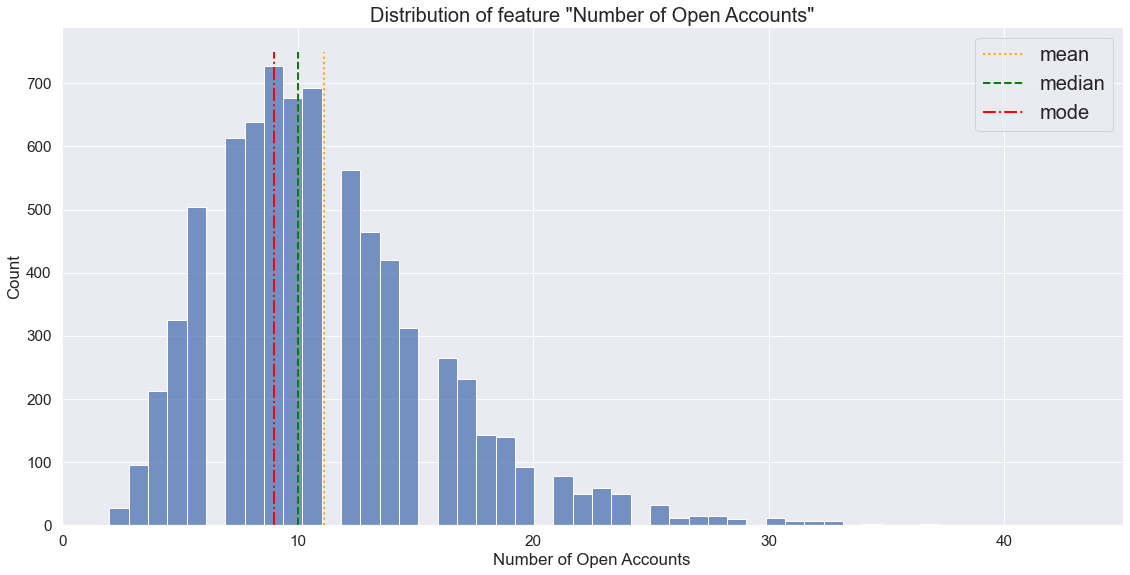

In [21]:
plt.figure(figsize = (15, 10))

sn.displot(data = X_train['Number of Open Accounts'], bins = 50, height = 8, aspect = 2, log_scale = False)

y = np.linspace(0, 750, 10)

plt.plot([np.round(X_train['Number of Open Accounts'].mean(), 2)] * 10, y, linewidth = 2, color = 'orange', linestyle = ':', label = 'mean')
plt.plot([np.round(X_train['Number of Open Accounts'].median(), 2)] * 10, y, linewidth = 2, color = 'green', linestyle = '--', label = 'median')
plt.plot([np.round(X_train['Number of Open Accounts'].mode()[0], 2)] * 10, y, linewidth = 2, color = 'red', linestyle = '-.', label = 'mode')

plt.legend(fontsize = 20)
plt.title('Distribution of feature "Number of Open Accounts"', fontsize = 20)

plt.show()

In [22]:
print(f"Mean:\t{np.round(X_train['Number of Open Accounts'].mean())}")
print(f"Median:\t{np.round(X_train['Number of Open Accounts'].median())}")
print(f"Mode:\t{np.round(X_train['Number of Open Accounts'].mode()[0])}")
print(f"Min:\t{np.round(X_train['Number of Open Accounts'].min())}")
print(f"Max:\t{np.round(X_train['Number of Open Accounts'].max())}")
print(f"Gaps:\t{X_train.shape[0] - X_train['Number of Open Accounts'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Number of Open Accounts'].count()) / X_train.shape[0]) * 100, 2)}")

Mean:	11.0
Median:	10.0
Mode:	9.0
Min:	2.0
Max:	43.0
Gaps:	0
Gaps %:	0.0


Предобработка данного признака не требуется.

Не содержит пропусков.

#### Years of Credit History - количество лет кредитной истории

<Figure size 1080x720 with 0 Axes>

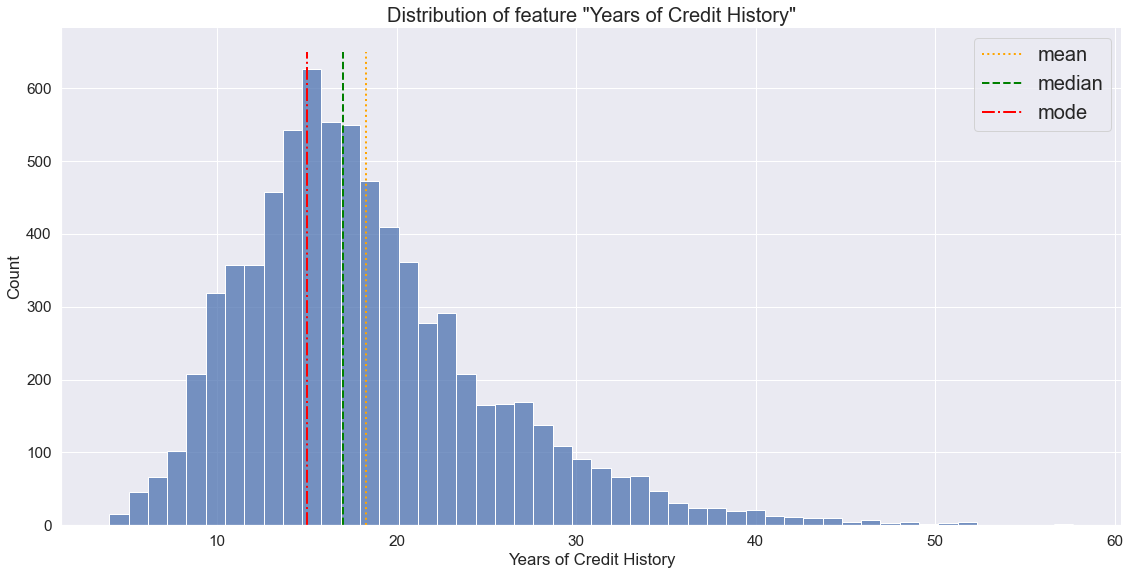

In [23]:
plt.figure(figsize = (15, 10))

sn.displot(data = X_train['Years of Credit History'], bins = 50, height = 8, aspect = 2, log_scale = False)

y = np.linspace(0, 650, 10)

plt.plot([np.round(X_train['Years of Credit History'].mean(), 2)] * 10, y, linewidth = 2, color = 'orange', linestyle = ':', label = 'mean')
plt.plot([np.round(X_train['Years of Credit History'].median(), 2)] * 10, y, linewidth = 2, color = 'green', linestyle = '--', label = 'median')
plt.plot([np.round(X_train['Years of Credit History'].mode()[0], 2)] * 10, y, linewidth = 2, color = 'red', linestyle = '-.', label = 'mode')

plt.legend(fontsize = 20)
plt.title('Distribution of feature "Years of Credit History"', fontsize = 20)

plt.show()

In [24]:
print(f"Mean:\t{np.round(X_train['Years of Credit History'].mean())}")
print(f"Median:\t{np.round(X_train['Years of Credit History'].median())}")
print(f"Mode:\t{np.round(X_train['Years of Credit History'].mode()[0])}")
print(f"Min:\t{np.round(X_train['Years of Credit History'].min())}")
print(f"Max:\t{np.round(X_train['Years of Credit History'].max())}")
print(f"Gaps:\t{X_train.shape[0] - X_train['Years of Credit History'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Years of Credit History'].count()) / X_train.shape[0]) * 100, 2)}")

Mean:	18.0
Median:	17.0
Mode:	15.0
Min:	4.0
Max:	58.0
Gaps:	0
Gaps %:	0.0


Предобработка данного признака не требуется.

Не содержит пропусков.

#### Maximum Open Credit - наибольший открытый кредит

<Figure size 1080x720 with 0 Axes>

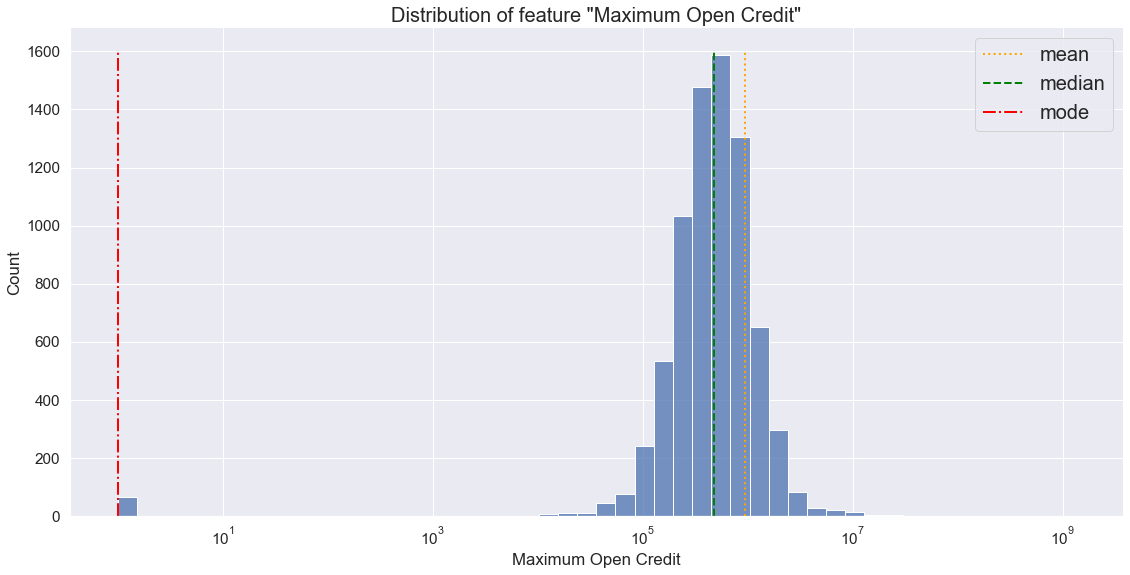

In [25]:
X_train_MOC = X_train['Maximum Open Credit'].copy()
X_train_MOC[X_train_MOC == 0] = 1

plt.figure(figsize = (15, 10))

sn.displot(data = X_train_MOC, bins = 50, height = 8, aspect = 2, log_scale = True)

y = np.linspace(0, 1600, 10)

plt.plot([np.round(X_train_MOC.mean(), 2)] * 10, y, linewidth = 2, color = 'orange', linestyle = ':', label = 'mean')
plt.plot([np.round(X_train_MOC.median(), 2)] * 10, y, linewidth = 2, color = 'green', linestyle = '--', label = 'median')
plt.plot([np.round(X_train_MOC.mode()[0], 2)] * 10, y, linewidth = 2, color = 'red', linestyle = '-.', label = 'mode')

plt.legend(fontsize = 20)
plt.title('Distribution of feature "Maximum Open Credit"', fontsize = 20)

plt.show()

In [26]:
print(f"Mean:\t{np.round(X_train['Maximum Open Credit'].mean())}")
print(f"Median:\t{np.round(X_train['Maximum Open Credit'].median())}")
print(f"Mode:\t{np.round(X_train['Maximum Open Credit'].mode()[0])}")
print(f"Min:\t{np.round(X_train['Maximum Open Credit'].min())}")
print(f"Max:\t{np.round(X_train['Maximum Open Credit'].max())}")
print(f"Gaps:\t{X_train.shape[0] - X_train['Maximum Open Credit'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Maximum Open Credit'].count()) / X_train.shape[0]) * 100, 2)}")

Mean:	945154.0
Median:	478159.0
Mode:	0.0
Min:	0.0
Max:	1304726170.0
Gaps:	0
Gaps %:	0.0


In [27]:
X_train['Maximum Open Credit'][X_train['Maximum Open Credit'] > X_train['Maximum Open Credit'].quantile(q = 0.999)]

44      3.800523e+08
617     1.304726e+09
2023    5.756256e+07
2617    2.655129e+08
2763    4.092389e+07
4769    2.634333e+07
5523    2.137243e+07
7026    2.640700e+07
Name: Maximum Open Credit, dtype: float64

Максимальные значения данного признака значительно превышают, на три порядка, среднее значение признака, что может сигнализировать о наличии выбросов.

Не содержит пропусков.

#### Number of Credit Problems - количество проблем с кредитом

In [28]:
X_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

Данный признак может быть переведён в dummies переменные:

    - без проблем;
    - одна проблема;
    - более одной проблемы.

Не содержит пропусков.

#### Months since last delinquent - количество месяцев с последней просрочки платежа

<Figure size 1080x720 with 0 Axes>

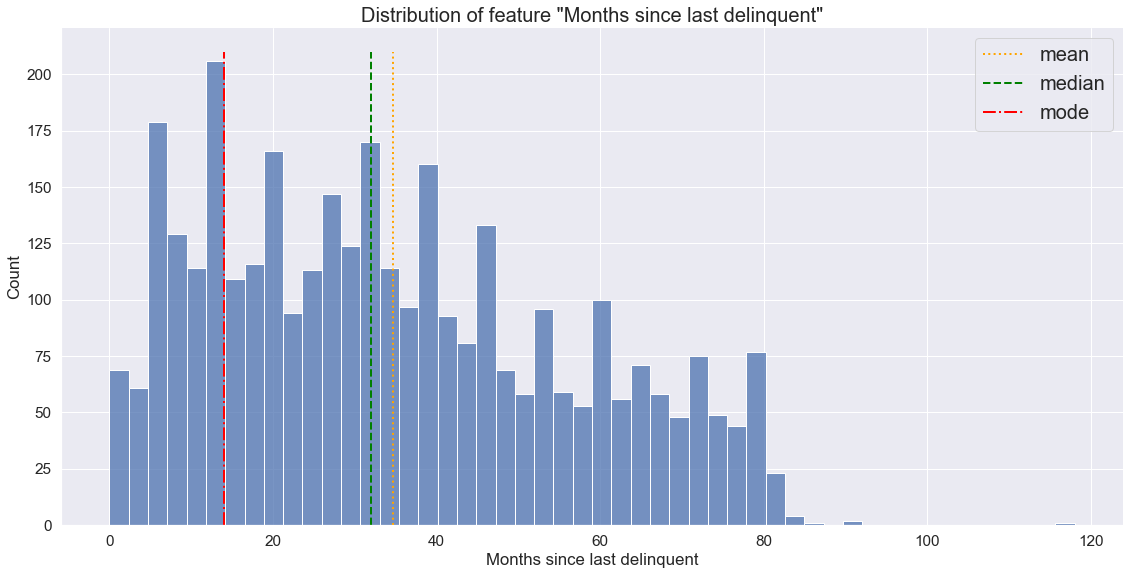

In [29]:
plt.figure(figsize = (15, 10))

sn.displot(data = X_train['Months since last delinquent'], bins = 50, height = 8, aspect = 2, log_scale = False)

y = np.linspace(0, 210, 10)

plt.plot([np.round(X_train['Months since last delinquent'].mean(), 2)] * 10, y, linewidth = 2, color = 'orange', linestyle = ':', label = 'mean')
plt.plot([np.round(X_train['Months since last delinquent'].median(), 2)] * 10, y, linewidth = 2, color = 'green', linestyle = '--', label = 'median')
plt.plot([np.round(X_train['Months since last delinquent'].mode()[0], 2)] * 10, y, linewidth = 2, color = 'red', linestyle = '-.', label = 'mode')

plt.legend(fontsize = 20)
plt.title('Distribution of feature "Months since last delinquent"', fontsize = 20)

plt.show()

In [30]:
print(f"Mean:\t{np.round(X_train['Months since last delinquent'].mean())}")
print(f"Median:\t{np.round(X_train['Months since last delinquent'].median())}")
print(f"Mode:\t{np.round(X_train['Months since last delinquent'].mode()[0])}")
print(f"Min:\t{np.round(X_train['Months since last delinquent'].min())}")
print(f"Max:\t{np.round(X_train['Months since last delinquent'].max())}")
print(f"Gaps:\t{X_train.shape[0] - X_train['Months since last delinquent'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Months since last delinquent'].count()) / X_train.shape[0]) * 100, 2)}")

Mean:	35.0
Median:	32.0
Mode:	14.0
Min:	0.0
Max:	118.0
Gaps:	4081
Gaps %:	54.41


Данный признак содержит значительное кол-во пропусков, более 54%, что может свидетельствовать как об отсутствии данных, так и об отсутствии просрочки платежа.

Рассмотрим записи, где имелись проблемы отдельно.

In [31]:
print(f"Number of records with credit problems: {X_train[X_train['Number of Credit Problems'] != 0].shape[0]}")
print(f"Number of records with credit problems and without 'Months since last delinquent' value: {X_train[(X_train['Number of Credit Problems'] != 0) & (X_train['Months since last delinquent'].isnull() == True)].shape[0]}")
print(f"Number of records without 'Months since last delinquent' value: {X_train[X_train['Months since last delinquent'].isnull() == True].shape[0]}")

Number of records with credit problems: 1031
Number of records with credit problems and without 'Months since last delinquent' value: 524
Number of records without 'Months since last delinquent' value: 4081


Гипотеза опровергнута, так как среди записей с проблемами присутствуют записи без значений признака "Months since last delinquent".

Данный признак может быть переведён в dummies переменные:

    - значение неизвестно;
    - менее года назад;
    - более года назад.

#### Bankruptcies - банкротства

In [32]:
X_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [33]:
print(f"Gaps:\t{X_train.shape[0] - X_train['Bankruptcies'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Bankruptcies'].count()) / X_train.shape[0]) * 100, 2)}")

Gaps:	14
Gaps %:	0.19


Данный признак содержит незначительное кол-во пропусков, менее 1%. Если рассмотреть пропуски как отсутсвие информации об известных банкротствах, то их можно заполнить значениями 0.

#### Purpose - цель кредита

In [34]:
X_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Возможно, данный признак лучше преобразовать в dummies переменную:

    - debt consoladation;
    - other.

Не содержит пропусков.

#### Term - срок кредита

In [35]:
X_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Возможно, данный признак лучше преобразовать в dummies переменную:

    - Short Term;
    - Long Term.

Не содержит пропусков.

#### Current Loan Amount - текущая сумма кредита

<Figure size 1080x720 with 0 Axes>

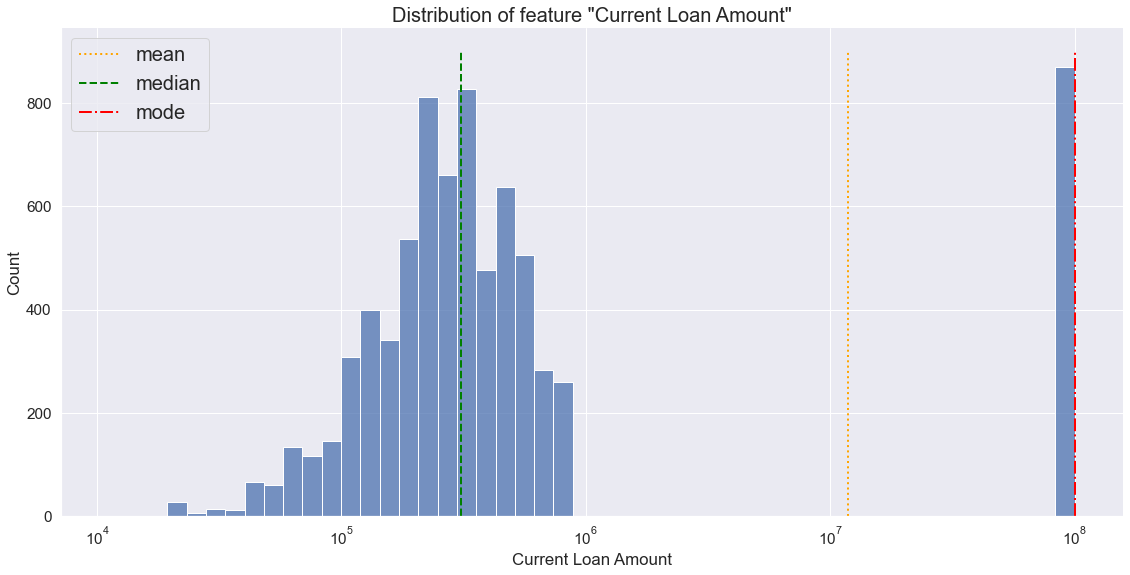

In [36]:
plt.figure(figsize = (15, 10))

sn.displot(data = X_train['Current Loan Amount'], bins = 50, height = 8, aspect = 2, log_scale = True)

y = np.linspace(0, 900, 10)

plt.plot([np.round(X_train['Current Loan Amount'].mean(), 2)] * 10, y, linewidth = 2, color = 'orange', linestyle = ':', label = 'mean')
plt.plot([np.round(X_train['Current Loan Amount'].median(), 2)] * 10, y, linewidth = 2, color = 'green', linestyle = '--', label = 'median')
plt.plot([np.round(X_train['Current Loan Amount'].mode()[0], 2)] * 10, y, linewidth = 2, color = 'red', linestyle = '-.', label = 'mode')

plt.legend(fontsize = 20)
plt.title('Distribution of feature "Current Loan Amount"', fontsize = 20)

plt.show()

In [37]:
print(f"Mean:\t{np.round(X_train['Current Loan Amount'].mean())}")
print(f"Median:\t{np.round(X_train['Current Loan Amount'].median())}")
print(f"Mode:\t{np.round(X_train['Current Loan Amount'].mode()[0])}")
print(f"Min:\t{np.round(X_train['Current Loan Amount'].min())}")
print(f"Max:\t{np.round(X_train['Current Loan Amount'].max())}")
print(f"Gaps:\t{X_train.shape[0] - X_train['Current Loan Amount'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Current Loan Amount'].count()) / X_train.shape[0]) * 100, 2)}")

Mean:	11873177.0
Median:	309573.0
Mode:	99999999.0
Min:	11242.0
Max:	99999999.0
Gaps:	0
Gaps %:	0.0


In [38]:
X_train['Current Loan Amount'].quantile(q = 0.9)

print(f"Quantile = 0.9:\t\t{X_train['Current Loan Amount'].quantile(q = 0.9)}")
print(f"Number of records:\t{X_train[X_train['Current Loan Amount'] >= X_train['Current Loan Amount'].quantile(q = 0.9)].shape[0]}")
print(f"Number of records %:\t{np.round((X_train[X_train['Current Loan Amount'] >= X_train['Current Loan Amount'].quantile(q = 0.9)].shape[0] / X_train.shape[0]) * 100, 2)}")

Quantile = 0.9:		99999999.0
Number of records:	870
Number of records %:	11.6


Существенное кол-во записей, более 11%, имеет значение признака "Current Loan Amount" значительно превышающее медианное значение, на три порядка. Данное превышение, а также смысловая интерпретация признака позволяют предпоожить, что данные значения заполнены с ошибкой. Например, сумма могла быть указана не в долларах, а в центах, что привело к увеличению в 100 раз.

Таким образом, данные значения должны быть скорректированы.

Данный признак оказывает существенное влияние на целевую переменную, коэффициент корреляции равен -0,23.

Не содержит пропусков.

#### Current Credit Balance - текущий кредитный баланс

<Figure size 1080x720 with 0 Axes>

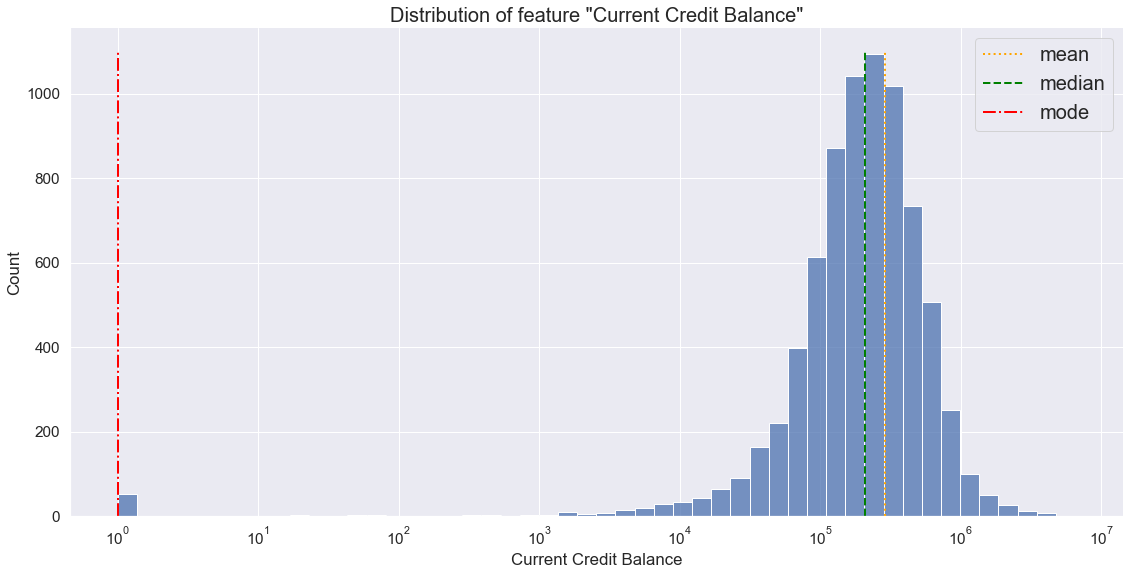

In [39]:
X_train_CCB = X_train['Current Credit Balance'].copy()
X_train_CCB[X_train_CCB == 0] = 1

plt.figure(figsize = (15, 10))

sn.displot(data = X_train_CCB, bins = 50, height = 8, aspect = 2, log_scale = True)

y = np.linspace(0, 1100, 10)

plt.plot([np.round(X_train_CCB.mean(), 2)] * 10, y, linewidth = 2, color = 'orange', linestyle = ':', label = 'mean')
plt.plot([np.round(X_train_CCB.median(), 2)] * 10, y, linewidth = 2, color = 'green', linestyle = '--', label = 'median')
plt.plot([np.round(X_train_CCB.mode()[0], 2)] * 10, y, linewidth = 2, color = 'red', linestyle = '-.', label = 'mode')

plt.legend(fontsize = 20)
plt.title('Distribution of feature "Current Credit Balance"', fontsize = 20)

plt.show()

In [40]:
print(f"Mean:\t{np.round(X_train['Current Credit Balance'].mean())}")
print(f"Median:\t{np.round(X_train['Current Credit Balance'].median())}")
print(f"Mode:\t{np.round(X_train['Current Credit Balance'].mode()[0])}")
print(f"Min:\t{np.round(X_train['Current Credit Balance'].min())}")
print(f"Max:\t{np.round(X_train['Current Credit Balance'].max())}")
print(f"Gaps:\t{X_train.shape[0] - X_train['Current Credit Balance'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Current Credit Balance'].count()) / X_train.shape[0]) * 100, 2)}")

Mean:	289833.0
Median:	209323.0
Mode:	0.0
Min:	0.0
Max:	6506797.0
Gaps:	0
Gaps %:	0.0


In [41]:
X_train['Current Credit Balance'].value_counts().head()

0.0         53
191710.0     5
106818.0     4
136401.0     4
82289.0      4
Name: Current Credit Balance, dtype: int64

Предобработка данного признака не требуется.

Не содержит пропусков.

#### Monthly Debt - ежемесячный долг

<Figure size 1080x720 with 0 Axes>

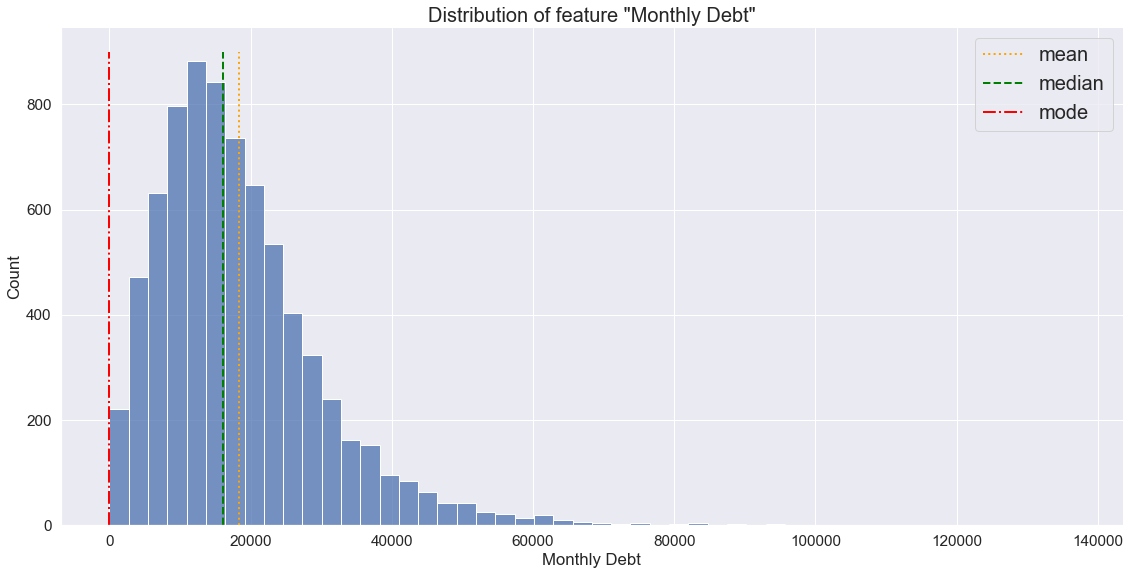

In [42]:
plt.figure(figsize = (15, 10))

sn.displot(data = X_train['Monthly Debt'], bins = 50, height = 8, aspect = 2, log_scale = False)

y = np.linspace(0, 900, 10)

plt.plot([np.round(X_train['Monthly Debt'].mean(), 2)] * 10, y, linewidth = 2, color = 'orange', linestyle = ':', label = 'mean')
plt.plot([np.round(X_train['Monthly Debt'].median(), 2)] * 10, y, linewidth = 2, color = 'green', linestyle = '--', label = 'median')
plt.plot([np.round(X_train['Monthly Debt'].mode()[0], 2)] * 10, y, linewidth = 2, color = 'red', linestyle = '-.', label = 'mode')

plt.legend(fontsize = 20)
plt.title('Distribution of feature "Monthly Debt"', fontsize = 20)

plt.show()

In [43]:
print(f"Mean:\t{np.round(X_train['Monthly Debt'].mean())}")
print(f"Median:\t{np.round(X_train['Monthly Debt'].median())}")
print(f"Mode:\t{np.round(X_train['Monthly Debt'].mode()[0])}")
print(f"Min:\t{np.round(X_train['Monthly Debt'].min())}")
print(f"Max:\t{np.round(X_train['Monthly Debt'].max())}")
print(f"Gaps:\t{X_train.shape[0] - X_train['Monthly Debt'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Monthly Debt'].count()) / X_train.shape[0]) * 100, 2)}")

Mean:	18314.0
Median:	16076.0
Mode:	0.0
Min:	0.0
Max:	136679.0
Gaps:	0
Gaps %:	0.0


In [44]:
X_train['Monthly Debt'].value_counts().head()

0.0        6
19667.0    4
19222.0    4
19277.0    3
9669.0     3
Name: Monthly Debt, dtype: int64

Предобработка данного признака не требуется.

Не содержит пропусков.

#### Credit Score

<Figure size 1080x720 with 0 Axes>

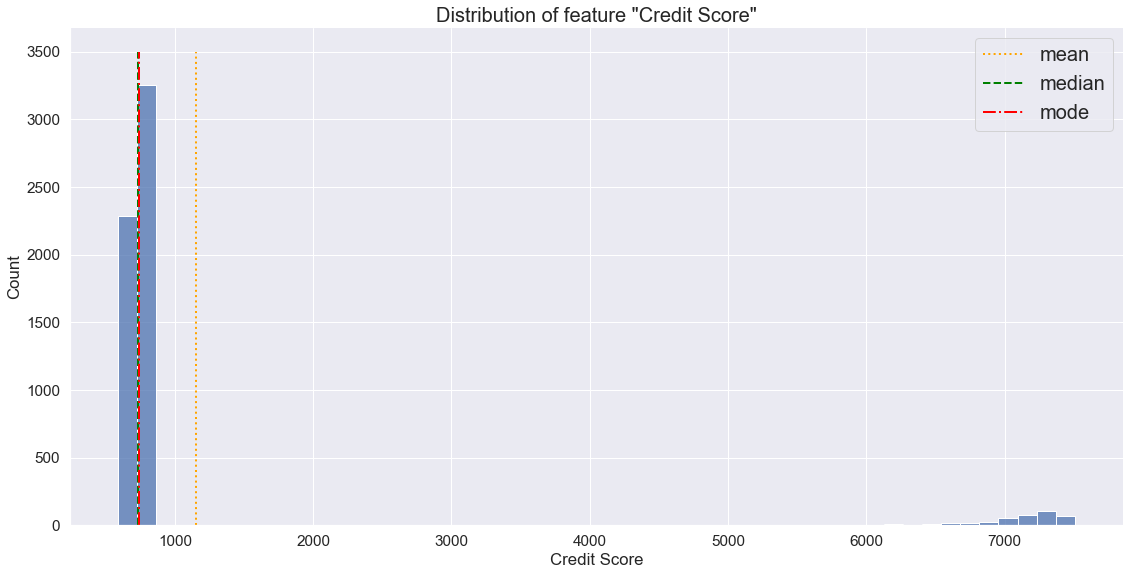

In [45]:
plt.figure(figsize = (15, 10))

sn.displot(data = X_train['Credit Score'], bins = 50, height = 8, aspect = 2, log_scale = False)

y = np.linspace(0, 3500, 10)

plt.plot([np.round(X_train['Credit Score'].mean(), 2)] * 10, y, linewidth = 2, color = 'orange', linestyle = ':', label = 'mean')
plt.plot([np.round(X_train['Credit Score'].median(), 2)] * 10, y, linewidth = 2, color = 'green', linestyle = '--', label = 'median')
plt.plot([np.round(X_train['Credit Score'].mode()[0], 2)] * 10, y, linewidth = 2, color = 'red', linestyle = '-.', label = 'mode')

plt.legend(fontsize = 20)
plt.title('Distribution of feature "Credit Score"', fontsize = 20)

plt.show()

In [46]:
print(f"Mean:\t{np.round(X_train['Credit Score'].mean())}")
print(f"Median:\t{np.round(X_train['Credit Score'].median())}")
print(f"Mode:\t{np.round(X_train['Credit Score'].mode()[0])}")
print(f"Min:\t{np.round(X_train['Credit Score'].min())}")
print(f"Max:\t{np.round(X_train['Credit Score'].max())}")
print(f"Gaps:\t{X_train.shape[0] - X_train['Credit Score'].count()}")
print(f"Gaps %:\t{np.round(((X_train.shape[0] - X_train['Credit Score'].count()) / X_train.shape[0]) * 100, 2)}")

Mean:	1151.0
Median:	731.0
Mode:	740.0
Min:	585.0
Max:	7510.0
Gaps:	1557
Gaps %:	20.76


Данный признак имеет значительное кол-во пропусков, более 20%, а также оказывает существенное влияние на целевую переменную, коэффициент корреляции равен 0,44. Таким образом, для результативного обучения модели необходимо качественное заполнение данного признака, либо исключение записей без значений данного признака в целях минимизации некорректного обучения.

#### Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [47]:
X_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [48]:
print(f"Ratio:\t{np.round(X_train[X_train['Credit Default'] == 0].shape[0] / X_train[X_train['Credit Default'] == 1].shape[0], 2)}")

Ratio:	2.55


Целевая переменная.
##### Соотношение двух классов целевой переменной 2,55 к 1, что требует балансировки классов.

## Data Preprocessing Class

In [49]:
class data_preprocessing():
    def __init__(self):
        self.Annual_Income_median = None
        self.Current_Loan_Amount_quantile = None
        self.Credit_Score_median = None
    
    def create_Id(self, df):
        # Создание признака Id
        df['Id'] = df.index.to_list()
        return df
    
    def feature_Home_Ownership(self, df):
        # Предобработка признака "Home Ownership": генерация dummies признаков
        df_copy = df[['Id', 'Home Ownership']].copy()
        df_copy = pd.get_dummies(df_copy)
        df = pd.merge(left = df, right = df_copy, how = 'inner', on = 'Id')
        df.drop(axis = 1, columns = 'Home Ownership', inplace = True)
        return df
    
    def feature_Annual_Income(self, df):
        # Предобработка признака "Annual Income": заполнение пропусков медианой
        if self.Annual_Income_median is None:
            self.Annual_Income_median = np.round(df['Annual Income'].median())
            
        df['Annual Income'].fillna(self.Annual_Income_median, inplace = True)
        
        # pd.to_pickle(obj = self.Annual_Income_median, filepath_or_buffer = PATH_VALUE_ANNUAL_INCOME_MEDIAN)
        return df
    
    def feature_Years_in_current_job(self, df):
        # Предобработка признака "Years in current job": генерация dummies признаков
        df['Years in current job_short'] = 0
        df['Years in current job_medium'] = 0
        df['Years in current job_long'] = 0
        
        df.loc[df['Years in current job'] == '< 1 year', 'Years in current job_short'] = 1
        df.loc[df['Years in current job'].isna() == True, 'Years in current job_short'] = 1
        
        df.loc[df['Years in current job'] == '1 year', 'Years in current job_medium'] = 1
        df.loc[df['Years in current job'] == '2 years', 'Years in current job_medium'] = 1
        df.loc[df['Years in current job'] == '3 years', 'Years in current job_medium'] = 1
        
        df.loc[df['Years in current job'] == '4 years', 'Years in current job_long'] = 1
        df.loc[df['Years in current job'] == '5 years', 'Years in current job_long'] = 1
        df.loc[df['Years in current job'] == '6 years', 'Years in current job_long'] = 1
        df.loc[df['Years in current job'] == '7 years', 'Years in current job_long'] = 1
        df.loc[df['Years in current job'] == '8 years', 'Years in current job_long'] = 1
        df.loc[df['Years in current job'] == '9 years', 'Years in current job_long'] = 1
        df.loc[df['Years in current job'] == '10+ years', 'Years in current job_long'] = 1
        
        df.drop(axis = 1, columns = 'Years in current job', inplace = True)
        return df
    
    def feature_Tax_Liens(self, df):
        # Предобработка признака "Tax Liens": генерация dummies признаков
        df['Tax Liens_0'] = 0
        df['Tax Liens_not_0'] = 0
        
        df.loc[df['Tax Liens'] == 0, 'Tax Liens_0'] = 1        
        df.loc[df['Tax Liens'] != 0, 'Tax Liens_not_0'] = 1
        
        df.drop(axis = 1, columns = 'Tax Liens', inplace = True)
        return df
    
    def feature_Maximum_Open_Credit(self, df):
        # Предобработка признака "Maximum Open Credit": обработка выбросов
        df.loc[df['Maximum Open Credit'] > np.power(10, 9), 'Maximum Open Credit'] = df['Maximum Open Credit'] / 1000
        df.loc[df['Maximum Open Credit'] > np.power(10, 8), 'Maximum Open Credit'] = df['Maximum Open Credit'] / 100
        df.loc[df['Maximum Open Credit'] > np.power(10, 7), 'Maximum Open Credit'] = df['Maximum Open Credit'] / 10
        return df
    
    def feature_Number_of_Credit_Problems(self, df):
        # Предобработка признака "Number of Credit Problems": генерация dummies признаков
        df['Number of Credit Problems_0'] = 0
        df['Number of Credit Problems_1'] = 0
        df['Number of Credit Problems_2+'] = 0
        
        df.loc[df['Number of Credit Problems'] == 0, 'Number of Credit Problems_0'] = 1
        df.loc[df['Number of Credit Problems'] == 1, 'Number of Credit Problems_1'] = 1
        df.loc[df['Number of Credit Problems'] >= 2, 'Number of Credit Problems_2+'] = 1
        
        df.drop(axis = 1, columns = 'Number of Credit Problems', inplace = True)
        return df
    
    def feature_Month_since_last_delinquent(self, df):
        # Предобработка признака "Months since last delinquent": генерация dummies признаков
        df['Months since last delinquent_unknown'] = 0
        df['Months since last delinquent_year-'] = 0
        df['Months since last delinquent_year+'] = 0
        
        df.loc[df['Months since last delinquent'].isna() == True, 'Months since last delinquent_unknown'] = 1
        df.loc[df['Months since last delinquent'] <= 12, 'Months since last delinquent_year-'] = 1
        df.loc[df['Months since last delinquent'] > 12, 'Months since last delinquent_year+'] = 1
        
        df.drop(axis = 1, columns = 'Months since last delinquent', inplace = True)
        return df
    
    def feature_Bankruptcies(self, df):
        # Предобработка признака "Bankruptcies": генерация dummies признаков
        df['Bankruptcies_0'] = 0
        df['Bankruptcies_1'] = 0
        df['Bankruptcies_2+'] = 0
        
        df.loc[df['Bankruptcies'] == 0, 'Bankruptcies_0'] = 1
        df.loc[df['Bankruptcies'].isna() == True, 'Bankruptcies_0'] = 1
        df.loc[df['Bankruptcies'] == 1, 'Bankruptcies_1'] = 1
        df.loc[df['Bankruptcies'] >= 2, 'Bankruptcies_2+'] = 1
        
        df.drop(axis = 1, columns = 'Bankruptcies', inplace = True)
        return df
    
    def feature_Purpose(self, df):
        # Предобработка признака "Purpose": генерация dummies признаков
        df['Purpose_debt'] = 0
        df['Purpose_other'] = 0
        
        df.loc[df['Purpose'] == 'debt consolidation', 'Purpose_debt'] = 1
        df.loc[df['Purpose'] != 'debt consolidation', 'Purpose_other'] = 1
        
        df.drop(axis = 1, columns = 'Purpose', inplace = True)
        return df
    
    def feature_Term(self, df):
        # Предобработка признака "Term": генерация dummies признаков
        df_copy = df[['Id', 'Term']].copy()
        df_copy = pd.get_dummies(df_copy)
        df = pd.merge(left = df, right = df_copy, how = 'inner', on = 'Id')
        df.drop(axis = 1, columns = 'Term', inplace = True)
        return df
    
    def feature_Current_Loan_Amount(self, df):
        # Предобработка признака "Current Loan Amount": обработка выбросов
        if self.Current_Loan_Amount_quantile is None:
            self.Current_Loan_Amount_quantile = df['Current Loan Amount'].quantile(q = 0.9)
        
        df.loc[df['Current Loan Amount'] >= self.Current_Loan_Amount_quantile,
               'Current Loan Amount'] = df['Current Loan Amount'] / 100
        
        # pd.to_pickle(obj = self.Current_Loan_Amount_quantile, filepath_or_buffer = PATH_VALUE_CURRENT_LOAN_AMOUNT_QUANTILE)
        return df
    
    def feature_Credit_Score(self, df):
        # Предобработка признака "Credit Score": обработка выбросов и пропусков
        if self.Credit_Score_median is None:
            self.Credit_Score_median = df['Credit Score'].median()
        
        df.loc[df['Credit Score'] > (self.Credit_Score_median * 2), 'Credit Score'] = df['Credit Score'] / 10
        df.loc[df['Credit Score'].isna() == True, 'Credit Score'] = df['Credit Score'].quantile(q = 0.25)
        
        # pd.to_pickle(obj = self.Credit_Score_median, filepath_or_buffer = PATH_VALUE_CREDIT_SCORE_MEDIAN)
        return df
    
    def drop_Id(self, df):
        # Удаление признака Id
        df.drop(axis = 1, columns = 'Id', inplace = True)
        return df
    
    def feature_balancing(self, df):
        # Балансировка классов
        df = df.append(X_train.loc[df['Credit Default'] == 1], ignore_index = True)
        return df
    
    def preprocessing_run(self, df):
        # Запуск предобработки признаков
        df = self.create_Id(df)
        df = self.feature_Home_Ownership(df)
        df = self.feature_Annual_Income(df)
        df = self.feature_Years_in_current_job(df)
        df = self.feature_Tax_Liens(df)
        df = self.feature_Maximum_Open_Credit(df)
        df = self.feature_Number_of_Credit_Problems(df)
        df = self.feature_Month_since_last_delinquent(df)
        df = self.feature_Bankruptcies(df)
        df = self.feature_Purpose(df)
        df = self.feature_Term(df)
        df = self.feature_Current_Loan_Amount(df)
        df = self.feature_Credit_Score(df)
        df = self.drop_Id(df)
        df['Number of Open Accounts'].astype(np.int64)
        df['Years of Credit History'].astype(np.int64)
        return df
    

## Model Building Class

In [50]:
class model_building():
    def __init__(self):
        # Список наиболее полезных признаков, установлен опытным путём
        self.important_features = ['Term_Long Term',
                                   'Number of Credit Problems_2+',
                                   'Home Ownership_Own Home',
                                   'Current Loan Amount',
                                   'Bankruptcies_0',
                                   'Credit Score',
                                   'Years in current job_short',
                                   'Number of Credit Problems_0',
                                   'Months since last delinquent_year-',
                                   'Annual Income',
                                   'Purpose_debt',
                                   'Bankruptcies_1',
                                   'Months since last delinquent_year+',
                                   'Maximum Open Credit',
                                   'Months since last delinquent_unknown',
                                   'Years in current job_medium',
                                   'Number of Open Accounts',
                                   'Home Ownership_Home Mortgage',
                                   'Years of Credit History',
                                   'Home Ownership_Rent',
                                   'Current Credit Balance',
                                   'Years in current job_long',
                                   'Monthly Debt',
                                   'Number of Credit Problems_1',
                                   'Tax Liens_0']
        
        # Наиболее результативные параметры модели, установлены опытным путём
        self.n_estimators = 300
        self.max_depth = 27
        self.min_saples_leaf = 15
        self.random_state = 100
    
    def fit(self, df):
        # Обучение модели
        
        X = df.drop(axis = 1, columns = 'Credit Default').copy()
        y = df['Credit Default'].copy()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = self.random_state)
        
        model_xgb = xgb.XGBClassifier(n_estimators = self.n_estimators,
                                      max_depth = self.max_depth,
                                      min_saples_leaf = self.min_saples_leaf,
                                      random_state = self.random_state)

        model_xgb.fit(X_train[self.important_features], y_train)
        
        y_train_pred = model_xgb.predict(X_train[self.important_features])
        y_test_pred = model_xgb.predict(X_test[self.important_features])

        get_classification_report(y_train_true = y_train,
                                  y_train_pred = y_train_pred,
                                  y_test_true = y_test,
                                  y_test_pred = y_test_pred)

        with open(PATH_MODEL_XGB, 'wb') as file:
            pickle.dump(model_xgb, file)
        
        return None
    
    
    def predict(self, df):
        # Прогнозирование
        
        with open(PATH_MODEL_XGB, 'rb') as file:
            model_xgb = pickle.load(file)
            
        X_test = df.copy()
        
        df['Id'] = df.index.to_list()
        
        y_pred = model_xgb.predict(X_test[self.important_features])
        
        result = pd.DataFrame(zip(df['Id'], y_pred), columns = ['Id', 'Credit Default'])
        
        return result
        

## Launch

#### Preprocessing df "X_train"

In [51]:
dp = data_preprocessing()
X_train = dp.preprocessing_run(X_train)
X_train = dp.feature_balancing(X_train)
X_train = reduce_memory_usage(X_train)

Initial memory usage of dataframe:	1.89 Mb
Final memory usage of dataframe:	0.504 Mb
Memory usage has been decreased by:	73.296 %


In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9613 entries, 0 to 9612
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Annual Income                         9613 non-null   float32
 1   Number of Open Accounts               9613 non-null   float32
 2   Years of Credit History               9613 non-null   float32
 3   Maximum Open Credit                   9613 non-null   float32
 4   Current Loan Amount                   9613 non-null   float32
 5   Current Credit Balance                9613 non-null   float32
 6   Monthly Debt                          9613 non-null   float32
 7   Credit Score                          9613 non-null   float32
 8   Credit Default                        9613 non-null   int8   
 9   Home Ownership_Have Mortgage          9613 non-null   uint8  
 10  Home Ownership_Home Mortgage          9613 non-null   uint8  
 11  Home Ownership_Ow

In [53]:
X_train.to_pickle(PATH_DATA_TRAIN_PREPROCESSED)

#### Preprocessing df "X_test"

In [54]:
X_test = pd.read_csv(PATH_DATA_TEST)
X_test = dp.preprocessing_run(X_test)
X_test = reduce_memory_usage(X_test)

Initial memory usage of dataframe:	0.554 Mb
Final memory usage of dataframe:	0.211 Mb
Memory usage has been decreased by:	61.953 %


In [55]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Annual Income                         2500 non-null   float32
 1   Number of Open Accounts               2500 non-null   float32
 2   Years of Credit History               2500 non-null   float32
 3   Maximum Open Credit                   2500 non-null   float32
 4   Current Loan Amount                   2500 non-null   float32
 5   Current Credit Balance                2500 non-null   float32
 6   Monthly Debt                          2500 non-null   float32
 7   Credit Score                          2500 non-null   float32
 8   Home Ownership_Have Mortgage          2500 non-null   uint8  
 9   Home Ownership_Home Mortgage          2500 non-null   uint8  
 10  Home Ownership_Own Home               2500 non-null   uint8  
 11  Home Ownership_Re

In [56]:
X_test.to_pickle(PATH_DATA_TEST_PREPROCESSED)

#### Model building

In [57]:
mb = model_building()

In [58]:
mb.fit(X_train)

[17:56:46] WARNING: ..\src\learner.cc:541: 
Parameters: { min_saples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:56:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\SergeyZ06\miniconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4034
           1       1.00      1.00      1.00      3175

    accuracy                           1.00      7209
   macro avg       1.00      1.00      1.00      7209
weighted avg       1.00      1.00      1.00      7209

TEST

              precision    recall  f1-score   support

           0       0.88      0.80      0.83      1353
           1       0.77      0.86      0.81      1051

    accuracy                           0.82      2404
   macro avg       0.82      0.83      0.82      2404
weighted avg       0.83      0.82      0.82      2404

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1077  276
1                150  901


In [59]:
result = mb.predict(X_test)

In [60]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Id              2500 non-null   int64
 1   Credit Default  2500 non-null   int64
dtypes: int64(2)
memory usage: 39.2 KB


In [61]:
result.to_csv(PATH_DATA_RESULT, index = False)